# Бинарная классификация: лоссы, метрики и методы работы с дисбалансом

Исследование различных подходов к бинарной классификации, включая функции потерь, метрики, методы работы с дисбалансом классов и калибровку модели.


In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from torchmetrics.classification import (
    BinaryAccuracy, BinaryPrecision, BinaryRecall, BinaryF1Score,
    BinaryAUROC, BinaryAveragePrecision
)
from torchmetrics.functional.classification import (
    binary_roc, binary_precision_recall_curve
)
from sklearn.utils import resample
from sklearn.calibration import calibration_curve
from torch.utils.data import WeightedRandomSampler
from adult_data import AdultDataModule
from mlp_model import MLPClassifier
from lightning_module import BaseLightningModule
from utils import set_seed
from pytorch_lightning import Trainer

sns.set_style("whitegrid")
set_seed(42)


## 1. Разница между BCEWithLogitsLoss и BCE Loss

**BCE (Binary Cross Entropy)** вычисляет потерю напрямую от вероятностей:

$$L_{BCE} = -\frac{1}{N}\sum_{i=1}^{N}[y_i \log(p_i) + (1-y_i)\log(1-p_i)]$$

где $p_i = \sigma(x_i)$ - вероятность после применения сигмоиды.

**BCEWithLogitsLoss** объединяет сигмоиду и BCE в одну операцию, что численно стабильнее:

$$L_{BCEWithLogits} = -\frac{1}{N}\sum_{i=1}^{N}[y_i \log(\sigma(x_i)) + (1-y_i)\log(1-\sigma(x_i))]$$

где $\sigma(x_i) = \frac{1}{1+e^{-x_i}}$ - сигмоида.

Преимущества BCEWithLogitsLoss:
- Численная стабильность: избегает проблем с очень большими/маленькими значениями в логарифме
- Вычислительная эффективность: объединенная операция быстрее
- Более точные градиенты при экстремальных значениях


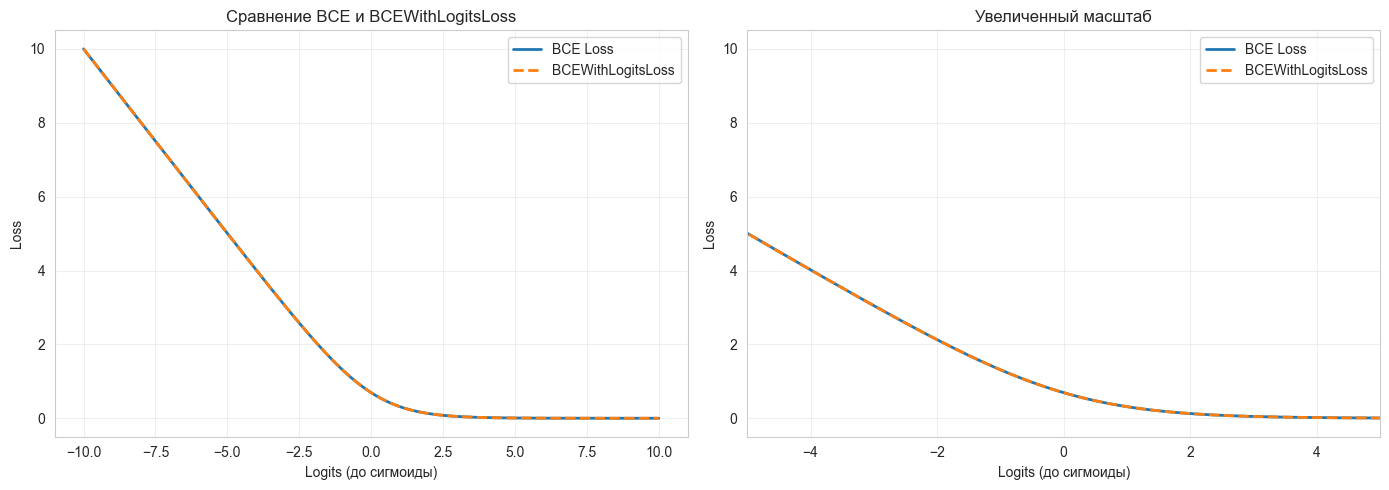

Максимальная разница: 9.54e-07
Средняя разница: 3.17e-08


In [2]:
logits = torch.linspace(-10, 10, 1000, requires_grad=True)

bce_with_logits = nn.BCEWithLogitsLoss(reduction='none')
bce = nn.BCELoss(reduction='none')
sigmoid = nn.Sigmoid()

targets = torch.ones_like(logits)

probs = sigmoid(logits)
loss_bce = bce(probs, targets)
loss_bce_with_logits = bce_with_logits(logits, targets)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(logits.detach().numpy(), loss_bce.detach().numpy(), label='BCE Loss', linewidth=2)
axes[0].plot(logits.detach().numpy(), loss_bce_with_logits.detach().numpy(), label='BCEWithLogitsLoss', linewidth=2, linestyle='--')
axes[0].set_xlabel('Logits (до сигмоиды)')
axes[0].set_ylabel('Loss')
axes[0].set_title('Сравнение BCE и BCEWithLogitsLoss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(logits.detach().numpy(), loss_bce.detach().numpy(), label='BCE Loss', linewidth=2)
axes[1].plot(logits.detach().numpy(), loss_bce_with_logits.detach().numpy(), label='BCEWithLogitsLoss', linewidth=2, linestyle='--')
axes[1].set_xlabel('Logits (до сигмоиды)')
axes[1].set_ylabel('Loss')
axes[1].set_title('Увеличенный масштаб')
axes[1].set_xlim(-5, 5)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Максимальная разница: {torch.max(torch.abs(loss_bce - loss_bce_with_logits)).item():.2e}")
print(f"Средняя разница: {torch.mean(torch.abs(loss_bce - loss_bce_with_logits)).item():.2e}")


## 2. Обучение модели на BCEWithLogitsLoss

Обучим модель бинарной классификации на датасете Adult с использованием BCEWithLogitsLoss. Модель будет предсказывать, зарабатывает ли человек больше 50K в год.

Используем MLP классификатор с несколькими скрытыми слоями и dropout для регуляризации.


In [3]:
data_module = AdultDataModule(batch_size=64, val_split=0.2, random_state=42)
data_module.setup()

model = MLPClassifier(
    input_dim=data_module.input_dim,
    n_classes=1,
    hidden_dims=[128, 64, 32],
    activation='relu',
    dropout=0.3
)

loss_fn = nn.BCEWithLogitsLoss()

lightning_module = BaseLightningModule(
    model=model,
    loss_fn=loss_fn,
    optimizer_type='adam',
    learning_rate=1e-3,
    task_type='binary_classification'
)

trainer = Trainer(
    max_epochs=20,
    enable_progress_bar=True,
    enable_model_summary=True
)

trainer.fit(lightning_module, data_module)


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA L40') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Epoch 0: accuracy=0.7891, precision=0.0000, recall=0.0000, f1=0.0000, roc_auc=0.6681, pr_auc=0.3426


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0: accuracy=0.8588, precision=0.7539, recall=0.6076, f1=0.6729, roc_auc=0.9097, pr_auc=0.7771


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1: accuracy=0.8601, precision=0.7585, recall=0.6090, f1=0.6756, roc_auc=0.9120, pr_auc=0.7815


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2: accuracy=0.8607, precision=0.7625, recall=0.6066, f1=0.6757, roc_auc=0.9129, pr_auc=0.7839


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3: accuracy=0.8610, precision=0.7568, recall=0.6171, f1=0.6799, roc_auc=0.9133, pr_auc=0.7851


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4: accuracy=0.8611, precision=0.7543, recall=0.6223, f1=0.6819, roc_auc=0.9137, pr_auc=0.7861


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5: accuracy=0.8613, precision=0.7527, recall=0.6258, f1=0.6834, roc_auc=0.9140, pr_auc=0.7867


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6: accuracy=0.8616, precision=0.7521, recall=0.6287, f1=0.6849, roc_auc=0.9143, pr_auc=0.7873


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7: accuracy=0.8618, precision=0.7520, recall=0.6303, f1=0.6858, roc_auc=0.9144, pr_auc=0.7876


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8: accuracy=0.8616, precision=0.7550, recall=0.6242, f1=0.6834, roc_auc=0.9143, pr_auc=0.7875


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9: accuracy=0.8616, precision=0.7565, recall=0.6216, f1=0.6824, roc_auc=0.9143, pr_auc=0.7874


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10: accuracy=0.8616, precision=0.7563, recall=0.6219, f1=0.6826, roc_auc=0.9143, pr_auc=0.7875


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11: accuracy=0.8614, precision=0.7545, recall=0.6235, f1=0.6828, roc_auc=0.9142, pr_auc=0.7875


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12: accuracy=0.8612, precision=0.7509, recall=0.6284, f1=0.6842, roc_auc=0.9141, pr_auc=0.7870


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13: accuracy=0.8610, precision=0.7481, recall=0.6320, f1=0.6852, roc_auc=0.9140, pr_auc=0.7866


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14: accuracy=0.8609, precision=0.7467, recall=0.6336, f1=0.6855, roc_auc=0.9139, pr_auc=0.7865


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15: accuracy=0.8608, precision=0.7464, recall=0.6338, f1=0.6855, roc_auc=0.9138, pr_auc=0.7862


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16: accuracy=0.8608, precision=0.7458, recall=0.6347, f1=0.6857, roc_auc=0.9136, pr_auc=0.7859


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17: accuracy=0.8607, precision=0.7442, recall=0.6368, f1=0.6863, roc_auc=0.9134, pr_auc=0.7855


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18: accuracy=0.8604, precision=0.7407, recall=0.6409, f1=0.6872, roc_auc=0.9132, pr_auc=0.7848


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: accuracy=0.8604, precision=0.7414, recall=0.6401, f1=0.6871, roc_auc=0.9131, pr_auc=0.7846


## 3. Метрики бинарной классификации

**Accuracy (Точность)**: доля правильно классифицированных примеров

$$Accuracy = \frac{TP + TN}{TP + TN + FP + FN}$$

**Precision (Точность предсказаний)**: доля положительных предсказаний, которые действительно положительные

$$Precision = \frac{TP}{TP + FP}$$

**Recall (Полнота)**: доля положительных примеров, которые были правильно предсказаны

$$Recall = \frac{TP}{TP + FN}$$

**F1 Score (micro)**: гармоническое среднее Precision и Recall

$$F1 = 2 \cdot \frac{Precision \cdot Recall}{Precision + Recall}$$

**ROC-AUC**: площадь под кривой ROC - показывает способность модели различать классы

$$AUC = \int_0^1 TPR(FPR^{-1}(\alpha)) d\alpha$$

где TPR (True Positive Rate) = Recall, FPR (False Positive Rate) = $\frac{FP}{FP + TN}$

**PR-AUC (Average Precision)**: площадь под кривой Precision-Recall - лучше для несбалансированных данных

$$AP = \sum_n (R_n - R_{n-1}) P_n$$

где $P_n$ и $R_n$ - precision и recall на n-м пороге


Accuracy: 0.8617
Precision: 0.7548
Recall: 0.6253
F1 Score: 0.6840
ROC-AUC: 0.9109
PR-AUC: 0.7830


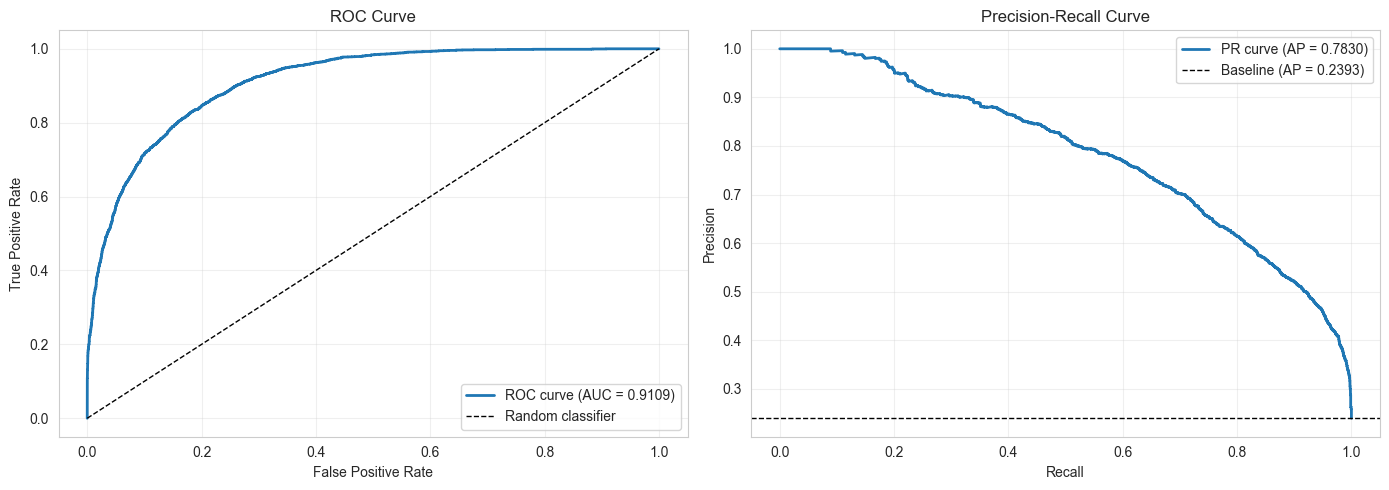

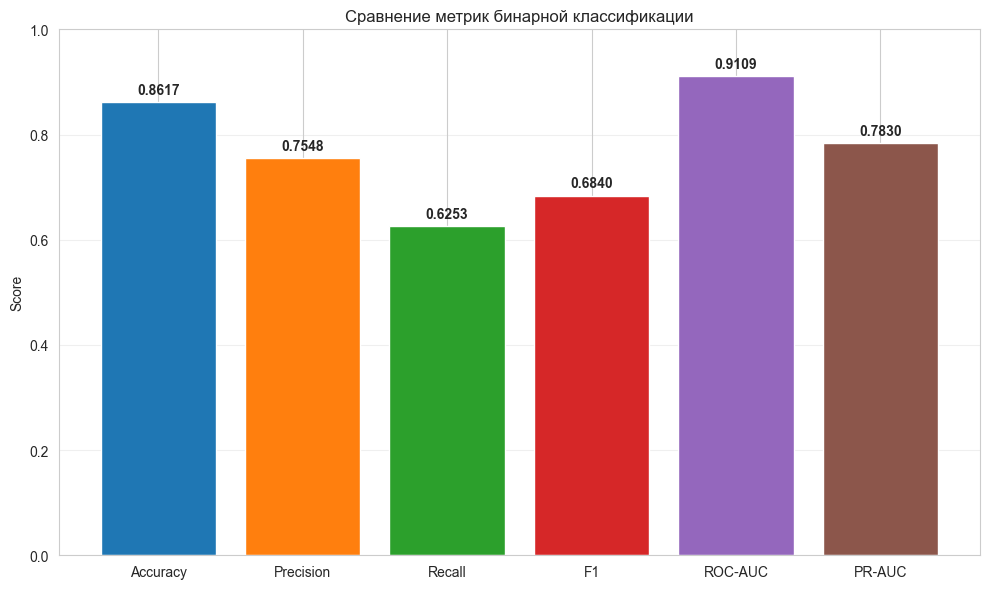

In [4]:
lightning_module.eval()
model.eval()

y_true_all = []
y_proba_all = []

with torch.no_grad():
    for batch in data_module.val_dataloader():
        x, y = batch
        logits = model(x).squeeze()
        probs = torch.sigmoid(logits)
        y_true_all.append(y.numpy())
        y_proba_all.append(probs.numpy())

y_true = np.concatenate(y_true_all)
y_proba = np.concatenate(y_proba_all)
y_pred = (y_proba >= 0.5).astype(int)

y_true_tensor = torch.FloatTensor(y_true)
y_proba_tensor = torch.FloatTensor(y_proba)
y_pred_tensor = torch.FloatTensor(y_pred)
y_true_long = y_true_tensor.long()

accuracy_metric = BinaryAccuracy()
precision_metric = BinaryPrecision()
recall_metric = BinaryRecall()
f1_metric = BinaryF1Score()
roc_auc_metric = BinaryAUROC()
pr_auc_metric = BinaryAveragePrecision()

accuracy = accuracy_metric(y_pred_tensor, y_true_long).item()
precision = precision_metric(y_pred_tensor, y_true_long).item()
recall = recall_metric(y_pred_tensor, y_true_long).item()
f1 = f1_metric(y_pred_tensor, y_true_long).item()
roc_auc = roc_auc_metric(y_proba_tensor, y_true_long).item()
pr_auc = pr_auc_metric(y_proba_tensor, y_true_long).item()

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"PR-AUC: {pr_auc:.4f}")

fpr, tpr, _ = binary_roc(y_proba_tensor, y_true_long)
precision_curve, recall_curve, _ = binary_precision_recall_curve(y_proba_tensor, y_true_long)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})', linewidth=2)
axes[0].plot([0, 1], [0, 1], 'k--', label='Random classifier', linewidth=1)
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(recall_curve, precision_curve, label=f'PR curve (AP = {pr_auc:.4f})', linewidth=2)
baseline = np.sum(y_true) / len(y_true)
axes[1].axhline(y=baseline, color='k', linestyle='--', label=f'Baseline (AP = {baseline:.4f})', linewidth=1)
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curve')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC-AUC', 'PR-AUC'],
    'Value': [accuracy, precision, recall, f1, roc_auc, pr_auc]
})

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
bars = ax.bar(metrics_df['Metric'], metrics_df['Value'], color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b'])
ax.set_ylabel('Score')
ax.set_title('Сравнение метрик бинарной классификации')
ax.set_ylim(0, 1)
ax.grid(True, alpha=0.3, axis='y')

for i, (bar, val) in enumerate(zip(bars, metrics_df['Value'])):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
            f'{val:.4f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


Вычисляем метрики на валидационной выборке и строим графики ROC и Precision-Recall кривых для визуализации качества модели.


## 4. Анализ дисбаланса классов

Перед применением методов работы с дисбалансом, важно оценить степень дисбаланса в данных.

**Дисбаланс классов** возникает, когда один класс представлен значительно больше другого. Это может привести к тому, что модель будет предсказывать преимущественно мажорный класс.

**Метрики дисбаланса:**
- Соотношение классов: $\frac{n_{majority}}{n_{minority}}$
- Доля минорного класса: $\frac{n_{minority}}{n_{total}}$

Где $n_{majority}$ - количество примеров мажорного класса, $n_{minority}$ - количество примеров минорного класса, $n_{total}$ - общее количество примеров.

Проанализируем распределение классов в обучающей выборке.


Распределение классов в обучающей выборке:
  Отрицательный класс (0): 29724 примеров (76.07%)
  Положительный класс (1): 9349 примеров (23.93%)
  Всего примеров: 39073

Соотношение классов: 3.18:1
Доля минорного класса: 0.2393


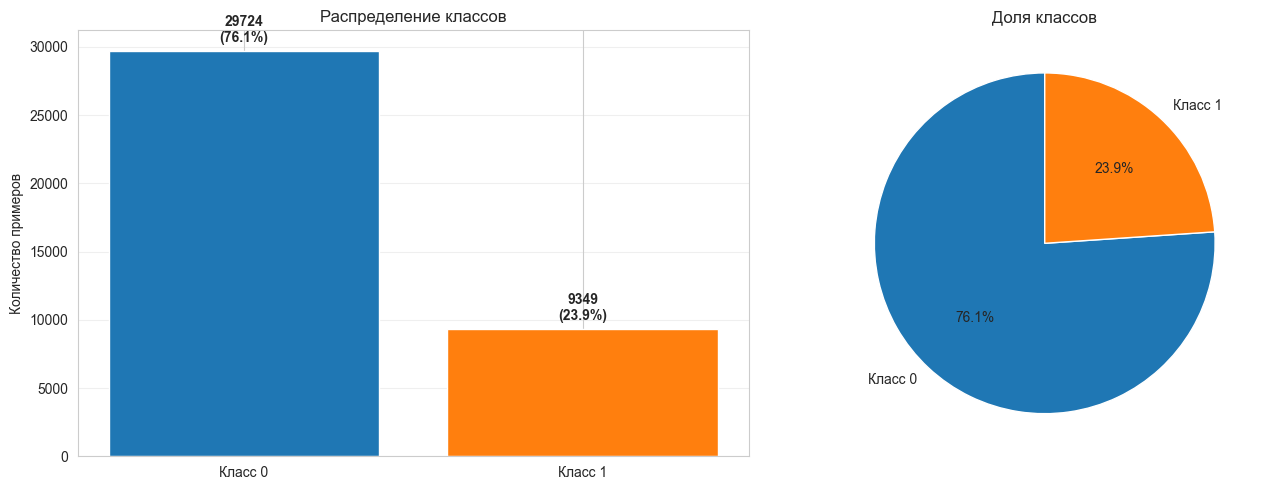


Оценка дисбаланса:
  Умеренный дисбаланс (соотношение 3.18:1)


In [5]:
train_dataset = data_module.train_dataset
y_train = train_dataset.y.numpy()

class_counts = np.bincount(y_train.astype(int))
n_total = len(y_train)
n_negative = class_counts[0]
n_positive = class_counts[1]

print(f"Распределение классов в обучающей выборке:")
print(f"  Отрицательный класс (0): {n_negative} примеров ({n_negative/n_total*100:.2f}%)")
print(f"  Положительный класс (1): {n_positive} примеров ({n_positive/n_total*100:.2f}%)")
print(f"  Всего примеров: {n_total}")
print(f"\nСоотношение классов: {n_negative/n_positive:.2f}:1")
print(f"Доля минорного класса: {n_positive/n_total:.4f}")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(['Класс 0', 'Класс 1'], [n_negative, n_positive], color=['#1f77b4', '#ff7f0e'])
axes[0].set_ylabel('Количество примеров')
axes[0].set_title('Распределение классов')
axes[0].grid(True, alpha=0.3, axis='y')

for i, (label, count) in enumerate([('Класс 0', n_negative), ('Класс 1', n_positive)]):
    axes[0].text(i, count + n_total*0.01, f'{count}\n({count/n_total*100:.1f}%)', 
                ha='center', va='bottom', fontweight='bold')

axes[1].pie([n_negative, n_positive], labels=['Класс 0', 'Класс 1'], 
           autopct='%1.1f%%', colors=['#1f77b4', '#ff7f0e'], startangle=90)
axes[1].set_title('Доля классов')

plt.tight_layout()
plt.show()

imbalance_ratio = n_negative / n_positive
print(f"\nОценка дисбаланса:")
if imbalance_ratio > 10:
    print(f"  Сильный дисбаланс (соотношение {imbalance_ratio:.2f}:1)")
elif imbalance_ratio > 3:
    print(f"  Умеренный дисбаланс (соотношение {imbalance_ratio:.2f}:1)")
else:
    print(f"  Слабый дисбаланс (соотношение {imbalance_ratio:.2f}:1)")


## 5. Работа с дисбалансом: Upsample и Downsample

При дисбалансе классов можно изменить распределение данных:

**Upsample (передискретизация)**: увеличение числа примеров минорного класса до размера мажорного класса

**Downsample (недостаточная выборка)**: уменьшение числа примеров мажорного класса до размера минорного класса

Оба метода изменяют соотношение классов, но могут привести к переобучению (upsample) или потере информации (downsample).


Исходное распределение:
target
0.0    29724
1.0     9349
Name: count, dtype: int64
Соотношение классов: 3.18:1


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



После Upsample:
target
1.0    29724
0.0    29724
Name: count, dtype: int64

После Downsample:
target
1.0    9349
0.0    9349
Name: count, dtype: int64

Обучение на исходных данных...
Epoch 0: accuracy=0.2109, precision=0.2109, recall=1.0000, f1=0.3484, roc_auc=0.5919, pr_auc=0.3660
Epoch 0: accuracy=0.8482, precision=0.7341, recall=0.5721, f1=0.6431, roc_auc=0.9087, pr_auc=0.7739
Epoch 1: accuracy=0.8541, precision=0.7458, recall=0.5915, f1=0.6598, roc_auc=0.9115, pr_auc=0.7805
Epoch 2: accuracy=0.8563, precision=0.7555, recall=0.5904, f1=0.6628, roc_auc=0.9127, pr_auc=0.7836
Epoch 3: accuracy=0.8579, precision=0.7515, recall=0.6067, f1=0.6713, roc_auc=0.9132, pr_auc=0.7851
Epoch 4: accuracy=0.8588, precision=0.7493, recall=0.6158, f1=0.6760, roc_auc=0.9135, pr_auc=0.7856
Epoch 5: accuracy=0.8594, precision=0.7514, recall=0.6160, f1=0.6770, roc_auc=0.9137, pr_auc=0.7862
Epoch 6: accuracy=0.8597, precision=0.7525, recall=0.6162, f1=0.6776, roc_auc=0.9139, pr_auc=0.7866
Epoch 7: accurac

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: accuracy=0.8602, precision=0.7498, recall=0.6243, f1=0.6813, roc_auc=0.9133, pr_auc=0.7859


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



Обучение на Upsampled данных...
Epoch 0: accuracy=0.7891, precision=0.0000, recall=0.0000, f1=0.0000, roc_auc=0.4631, pr_auc=0.1987
Epoch 0: accuracy=0.8079, precision=0.5648, recall=0.8554, f1=0.6803, roc_auc=0.9126, pr_auc=0.7825
Epoch 1: accuracy=0.8175, precision=0.5823, recall=0.8380, f1=0.6871, roc_auc=0.9132, pr_auc=0.7838
Epoch 2: accuracy=0.8131, precision=0.5737, recall=0.8510, f1=0.6854, roc_auc=0.9135, pr_auc=0.7857
Epoch 3: accuracy=0.8092, precision=0.5668, recall=0.8599, f1=0.6832, roc_auc=0.9134, pr_auc=0.7847
Epoch 4: accuracy=0.8090, precision=0.5665, recall=0.8583, f1=0.6825, roc_auc=0.9130, pr_auc=0.7844
Epoch 5: accuracy=0.8099, precision=0.5682, recall=0.8563, f1=0.6831, roc_auc=0.9128, pr_auc=0.7846
Epoch 6: accuracy=0.8084, precision=0.5657, recall=0.8583, f1=0.6819, roc_auc=0.9123, pr_auc=0.7843
Epoch 7: accuracy=0.8091, precision=0.5669, recall=0.8567, f1=0.6823, roc_auc=0.9117, pr_auc=0.7835
Epoch 8: accuracy=0.8084, precision=0.5657, recall=0.8578, f1=0.681

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: accuracy=0.8101, precision=0.5691, recall=0.8499, f1=0.6817, roc_auc=0.9087, pr_auc=0.7803


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



Обучение на Downsampled данных...
Epoch 0: accuracy=0.7891, precision=0.0000, recall=0.0000, f1=0.0000, roc_auc=0.5545, pr_auc=0.2392
Epoch 0: accuracy=0.8055, precision=0.5629, recall=0.8330, f1=0.6718, roc_auc=0.9065, pr_auc=0.7649
Epoch 1: accuracy=0.8081, precision=0.5666, recall=0.8399, f1=0.6767, roc_auc=0.9094, pr_auc=0.7721
Epoch 2: accuracy=0.8083, precision=0.5666, recall=0.8446, f1=0.6782, roc_auc=0.9109, pr_auc=0.7759
Epoch 3: accuracy=0.8030, precision=0.5574, recall=0.8574, f1=0.6756, roc_auc=0.9110, pr_auc=0.7761
Epoch 4: accuracy=0.8051, precision=0.5607, recall=0.8565, f1=0.6778, roc_auc=0.9118, pr_auc=0.7783
Epoch 5: accuracy=0.8027, precision=0.5567, recall=0.8614, f1=0.6763, roc_auc=0.9121, pr_auc=0.7794
Epoch 6: accuracy=0.8031, precision=0.5571, recall=0.8625, f1=0.6770, roc_auc=0.9124, pr_auc=0.7803
Epoch 7: accuracy=0.8035, precision=0.5578, recall=0.8627, f1=0.6775, roc_auc=0.9127, pr_auc=0.7808
Epoch 8: accuracy=0.8056, precision=0.5613, recall=0.8588, f1=0.6

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: accuracy=0.8050, precision=0.5603, recall=0.8596, f1=0.6784, roc_auc=0.9120, pr_auc=0.7793

Сравнение результатов:
          name  accuracy  precision  recall      f1  roc_auc  pr_auc
0     Original    0.8588     0.7361  0.6394  0.6844   0.9129  0.7850
1    Upsampled    0.8128     0.5752  0.8328  0.6804   0.9062  0.7778
2  Downsampled    0.7978     0.5491  0.8683  0.6727   0.9096  0.7728


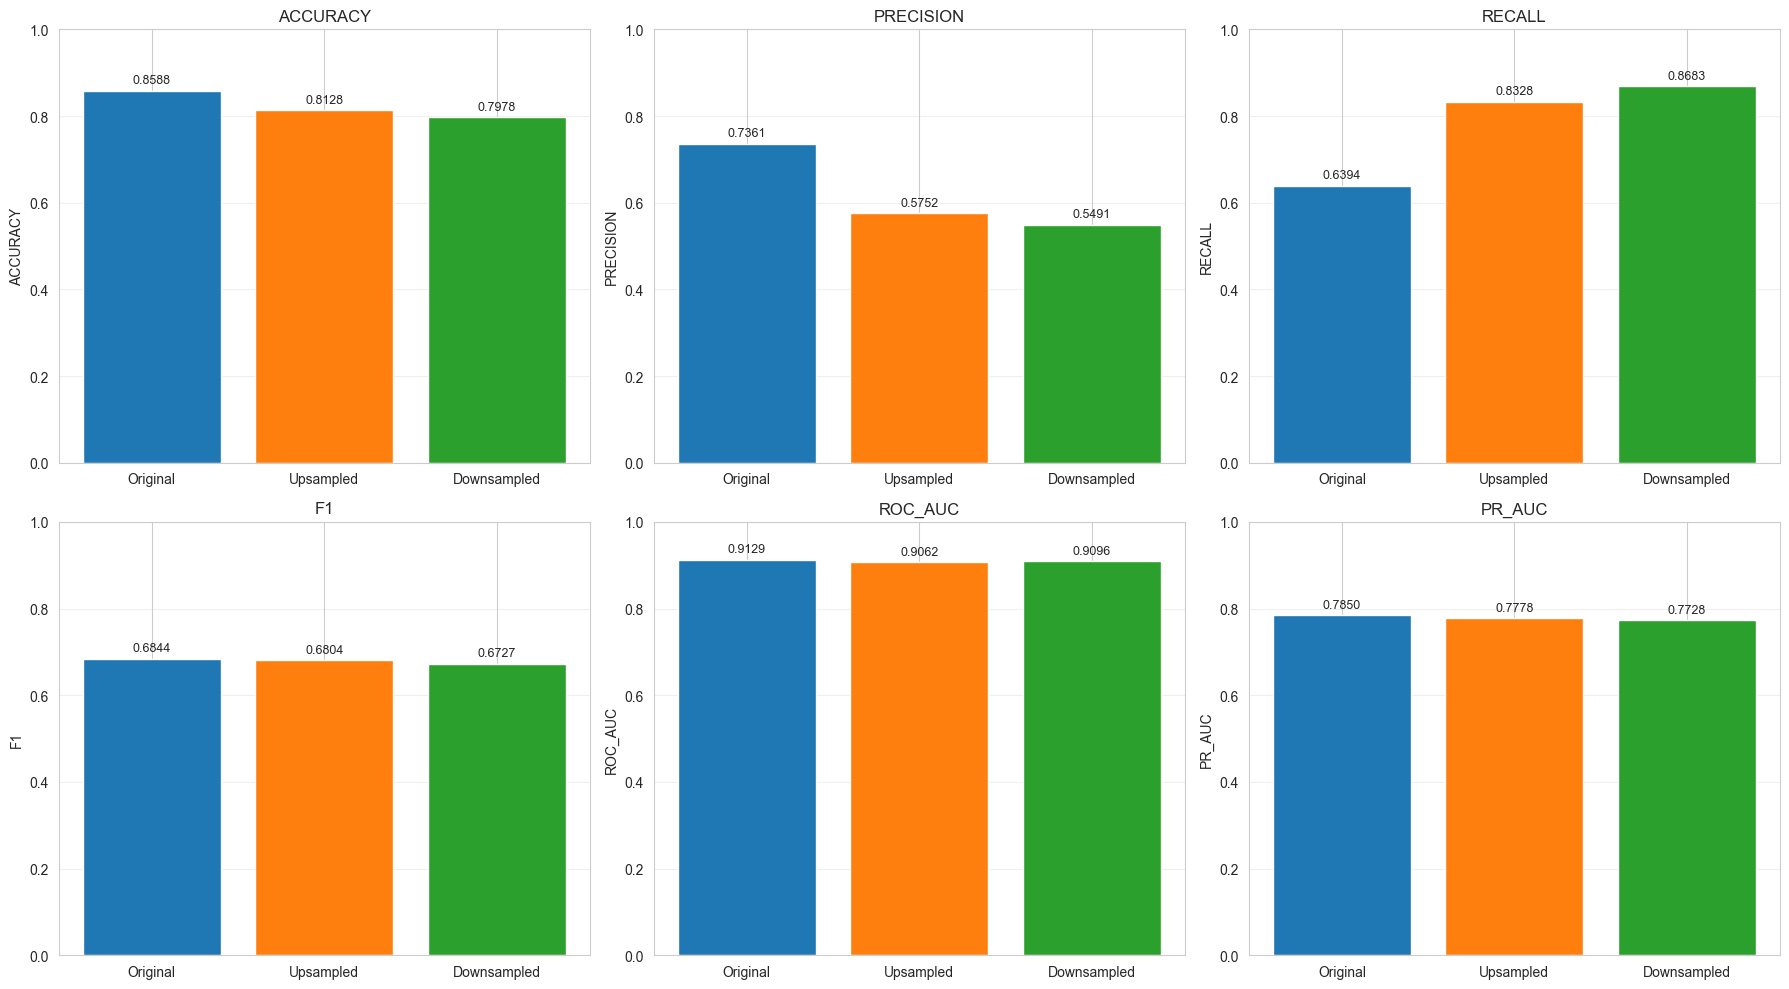

In [6]:
adult = data_module.train_dataset
X_train = adult.X.numpy()
y_train = adult.y.numpy()

df_train = pd.DataFrame(X_train)
df_train['target'] = y_train

print(f"Исходное распределение:")
print(df_train['target'].value_counts())
print(f"Соотношение классов: {df_train['target'].value_counts()[0] / df_train['target'].value_counts()[1]:.2f}:1")

majority_class = df_train[df_train['target'] == 0]
minority_class = df_train[df_train['target'] == 1]

df_upsampled_minority = resample(
    minority_class,
    replace=True,
    n_samples=len(majority_class),
    random_state=42
)

df_upsampled = pd.concat([majority_class, df_upsampled_minority])
df_upsampled = df_upsampled.sample(frac=1, random_state=42).reset_index(drop=True)

df_downsampled_majority = resample(
    majority_class,
    replace=False,
    n_samples=len(minority_class),
    random_state=42
)

df_downsampled = pd.concat([minority_class, df_downsampled_majority])
df_downsampled = df_downsampled.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"\nПосле Upsample:")
print(df_upsampled['target'].value_counts())

print(f"\nПосле Downsample:")
print(df_downsampled['target'].value_counts())

class UpsampledDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

upsampled_dataset = UpsampledDataset(
    df_upsampled.drop('target', axis=1).values,
    df_upsampled['target'].values
)

downsampled_dataset = UpsampledDataset(
    df_downsampled.drop('target', axis=1).values,
    df_downsampled['target'].values
)

val_dataset = data_module.val_dataset

def train_and_evaluate(train_dataset, name):
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=0)
    
    model = MLPClassifier(
        input_dim=data_module.input_dim,
        n_classes=1,
        hidden_dims=[128, 64, 32],
        activation='relu',
        dropout=0.3
    )
    
    loss_fn = nn.BCEWithLogitsLoss()
    lightning_module = BaseLightningModule(
        model=model,
        loss_fn=loss_fn,
        optimizer_type='adam',
        learning_rate=1e-3,
        task_type='binary_classification'
    )
    
    trainer = Trainer(
        max_epochs=15,
        enable_progress_bar=False,
        enable_model_summary=False
    )
    
    trainer.fit(lightning_module, train_loader, val_loader)
    
    lightning_module.eval()
    model.eval()
    
    y_true_all = []
    y_proba_all = []
    
    with torch.no_grad():
        for batch in val_loader:
            x, y = batch
            logits = model(x).squeeze()
            proba = torch.sigmoid(logits)
            y_true_all.append(y.numpy())
            y_proba_all.append(proba.numpy())
    
    y_true = np.concatenate(y_true_all)
    y_proba = np.concatenate(y_proba_all)
    y_pred = (y_proba >= 0.5).astype(int)
    
    y_true_tensor = torch.FloatTensor(y_true)
    y_proba_tensor = torch.FloatTensor(y_proba)
    y_pred_tensor = torch.FloatTensor(y_pred)
    y_true_long = y_true_tensor.long()
    
    accuracy_metric = BinaryAccuracy()
    precision_metric = BinaryPrecision()
    recall_metric = BinaryRecall()
    f1_metric = BinaryF1Score()
    roc_auc_metric = BinaryAUROC()
    pr_auc_metric = BinaryAveragePrecision()
    
    return {
        'name': name,
        'accuracy': accuracy_metric(y_pred_tensor, y_true_long).item(),
        'precision': precision_metric(y_pred_tensor, y_true_long).item(),
        'recall': recall_metric(y_pred_tensor, y_true_long).item(),
        'f1': f1_metric(y_pred_tensor, y_true_long).item(),
        'roc_auc': roc_auc_metric(y_proba_tensor, y_true_long).item(),
        'pr_auc': pr_auc_metric(y_proba_tensor, y_true_long).item()
    }

results = []

print("\nОбучение на исходных данных...")
results.append(train_and_evaluate(adult, 'Original'))

print("\nОбучение на Upsampled данных...")
results.append(train_and_evaluate(upsampled_dataset, 'Upsampled'))

print("\nОбучение на Downsampled данных...")
results.append(train_and_evaluate(downsampled_dataset, 'Downsampled'))

results_df = pd.DataFrame(results)
print("\nСравнение результатов:")
print(results_df.round(4))

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'pr_auc']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 3, idx % 3]
    bars = ax.bar(results_df['name'], results_df[metric], color=['#1f77b4', '#ff7f0e', '#2ca02c'])
    ax.set_ylabel(metric.upper())
    ax.set_title(f'{metric.upper()}')
    ax.set_ylim(0, 1)
    ax.grid(True, alpha=0.3, axis='y')
    
    for bar, val in zip(bars, results_df[metric]):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{val:.4f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


## 6. Работа с дисбалансом: pos_weight и class weights

Вместо изменения данных можно использовать веса классов в функции потерь:

**pos_weight** в BCEWithLogitsLoss: умножает потерю для положительного класса на этот коэффициент

$$L = -\frac{1}{N}\sum_{i=1}^{N}[w \cdot y_i \log(\sigma(x_i)) + (1-y_i)\log(1-\sigma(x_i))]$$

где $w = pos\_weight = \frac{n\_negative}{n\_positive}$

**class_weight**: словарь весов для каждого класса, используется в комбинации с WeightedRandomSampler или можно модифицировать loss вручную

Сравним обучение без весов и с весами.


Вычисляем pos_weight на основе соотношения классов в обучающей выборке и обучаем модели с весами и без них для сравнения эффективности.


Реализуем обучение с использованием pos_weight для балансировки классов без изменения данных.


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Количество положительных примеров: 9349
Количество отрицательных примеров: 29724
pos_weight = 3.1794

Обучение без весов...
Epoch 0: accuracy=0.7891, precision=0.0000, recall=0.0000, f1=0.0000, roc_auc=0.3256, pr_auc=0.1548
Epoch 0: accuracy=0.8516, precision=0.8023, recall=0.5027, f1=0.6181, roc_auc=0.9080, pr_auc=0.7702
Epoch 1: accuracy=0.8555, precision=0.7887, recall=0.5405, f1=0.6414, roc_auc=0.9113, pr_auc=0.7786
Epoch 2: accuracy=0.8579, precision=0.7778, recall=0.5681, f1=0.6566, roc_auc=0.9124, pr_auc=0.7817
Epoch 3: accuracy=0.8592, precision=0.7638, recall=0.5960, f1=0.6695, roc_auc=0.9128, pr_auc=0.7824
Epoch 4: accuracy=0.8596, precision=0.7579, recall=0.6068, f1=0.6740, roc_auc=0.9126, pr_auc=0.7831
Epoch 5: accuracy=0.8600, precision=0.7601, recall=0.6065, f1=0.6747, roc_auc=0.9131, pr_auc=0.7845
Epoch 6: accuracy=0.8605, precision=0.7589, recall=0.6111, f1=0.6770, roc_auc=0.9134, pr_auc=0.7853
Epoch 7: accuracy=0.8607, precision=0.7567, recall=0.6160, f1=0.6792, roc_au

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: accuracy=0.8607, precision=0.7512, recall=0.6248, f1=0.6822, roc_auc=0.9133, pr_auc=0.7850


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



Обучение с pos_weight...
Epoch 0: accuracy=0.7891, precision=0.0000, recall=0.0000, f1=0.0000, roc_auc=0.4415, pr_auc=0.2201
Epoch 0: accuracy=0.8175, precision=0.5847, recall=0.8161, f1=0.6813, roc_auc=0.9098, pr_auc=0.7756
Epoch 1: accuracy=0.8071, precision=0.5642, recall=0.8501, f1=0.6783, roc_auc=0.9111, pr_auc=0.7791
Epoch 2: accuracy=0.8054, precision=0.5609, recall=0.8597, f1=0.6789, roc_auc=0.9120, pr_auc=0.7816
Epoch 3: accuracy=0.8028, precision=0.5566, recall=0.8648, f1=0.6773, roc_auc=0.9120, pr_auc=0.7816
Epoch 4: accuracy=0.8054, precision=0.5607, recall=0.8615, f1=0.6793, roc_auc=0.9126, pr_auc=0.7828
Epoch 5: accuracy=0.8074, precision=0.5640, recall=0.8586, f1=0.6808, roc_auc=0.9130, pr_auc=0.7836
Epoch 6: accuracy=0.8083, precision=0.5656, recall=0.8571, f1=0.6815, roc_auc=0.9131, pr_auc=0.7840
Epoch 7: accuracy=0.8068, precision=0.5630, recall=0.8599, f1=0.6805, roc_auc=0.9132, pr_auc=0.7842
Epoch 8: accuracy=0.8067, precision=0.5628, recall=0.8606, f1=0.6805, roc_

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: accuracy=0.8100, precision=0.5685, recall=0.8550, f1=0.6829, roc_auc=0.9128, pr_auc=0.7848

Сравнение результатов:
           name  accuracy  precision  recall      f1  roc_auc  pr_auc
0     Без весов    0.8589     0.7497  0.6163  0.6765   0.9129  0.7835
1  С pos_weight    0.8102     0.5694  0.8494  0.6818   0.9115  0.7842


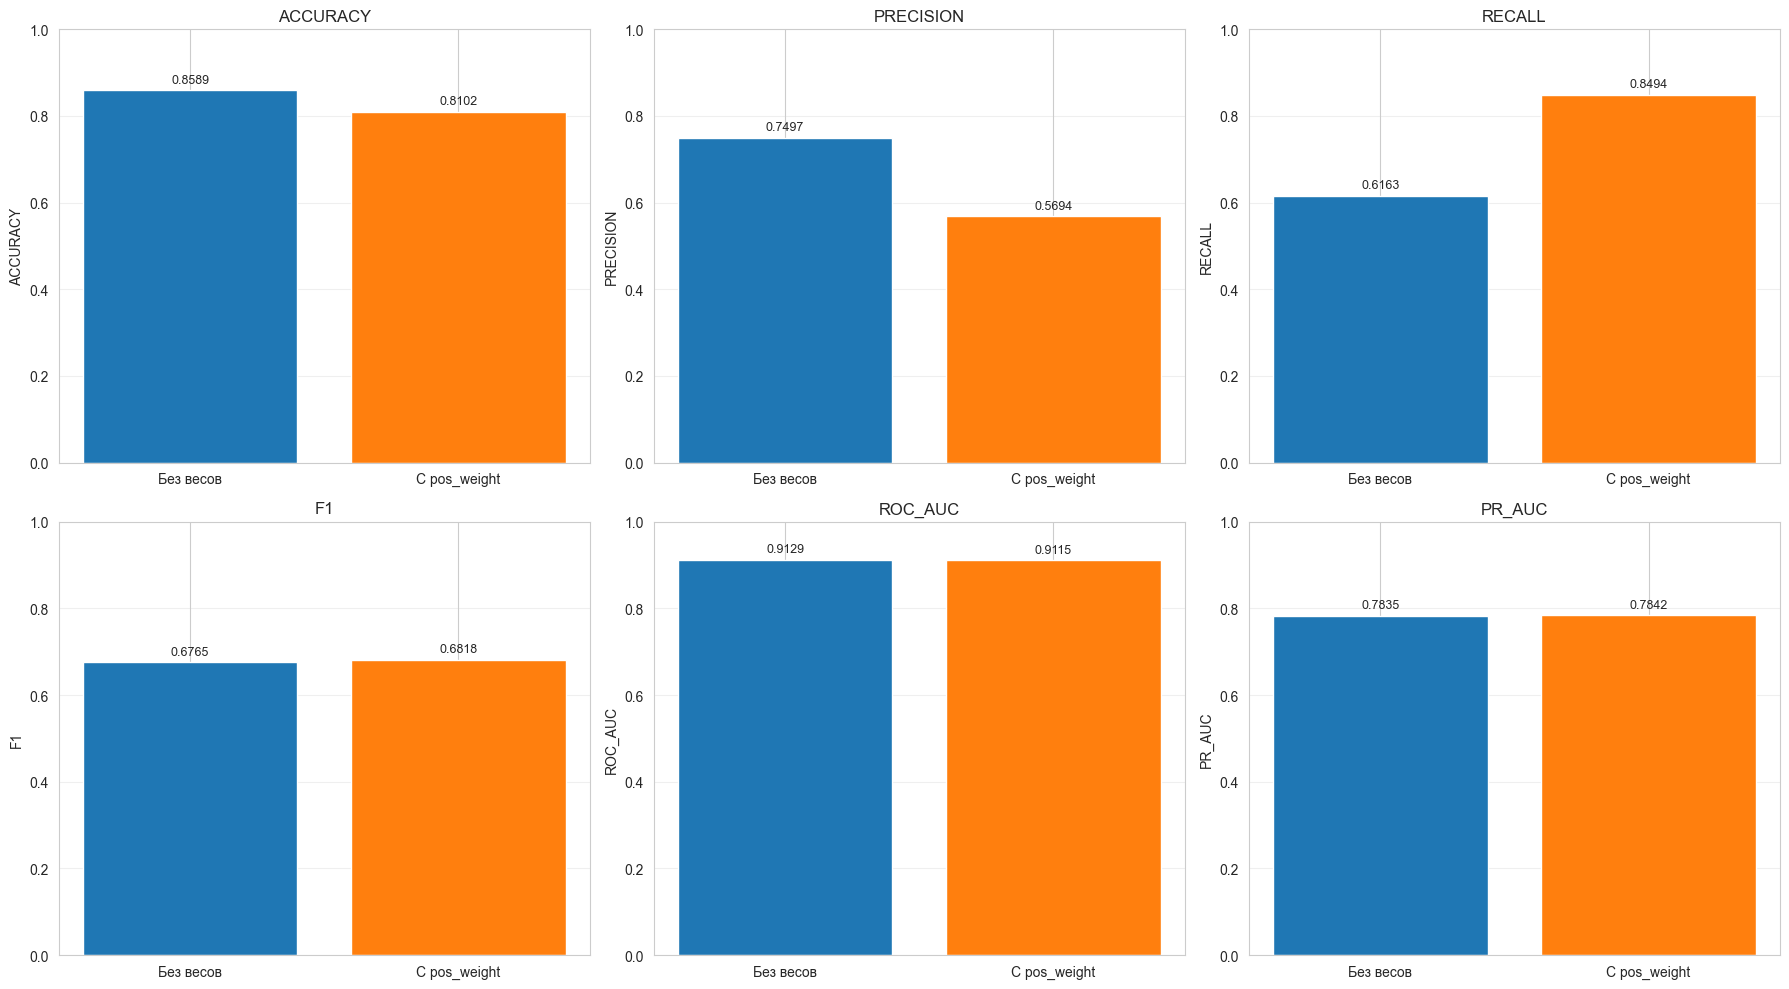

In [7]:
train_dataset = data_module.train_dataset
y_train = train_dataset.y.numpy()

n_pos = (y_train == 1).sum()
n_neg = (y_train == 0).sum()
pos_weight_value = n_neg / n_pos

print(f"Количество положительных примеров: {n_pos}")
print(f"Количество отрицательных примеров: {n_neg}")
print(f"pos_weight = {pos_weight_value:.4f}")

def train_with_weights(pos_weight, name):
    train_loader = data_module.train_dataloader()
    val_loader = data_module.val_dataloader()
    
    model = MLPClassifier(
        input_dim=data_module.input_dim,
        n_classes=1,
        hidden_dims=[128, 64, 32],
        activation='relu',
        dropout=0.3
    )
    
    if pos_weight is not None:
        loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([pos_weight]))
    else:
        loss_fn = nn.BCEWithLogitsLoss()
    
    lightning_module = BaseLightningModule(
        model=model,
        loss_fn=loss_fn,
        optimizer_type='adam',
        learning_rate=1e-3,
        task_type='binary_classification'
    )
    
    trainer = Trainer(
        max_epochs=15,
        enable_progress_bar=False,
        enable_model_summary=False
    )
    
    trainer.fit(lightning_module, train_loader, val_loader)
    
    lightning_module.eval()
    model.eval()
    
    y_true_all = []
    y_proba_all = []
    
    with torch.no_grad():
        for batch in val_loader:
            x, y = batch
            logits = model(x).squeeze()
            proba = torch.sigmoid(logits)
            y_true_all.append(y.numpy())
            y_proba_all.append(proba.numpy())
    
    y_true = np.concatenate(y_true_all)
    y_proba = np.concatenate(y_proba_all)
    y_pred = (y_proba >= 0.5).astype(int)
    
    y_true_tensor = torch.FloatTensor(y_true)
    y_proba_tensor = torch.FloatTensor(y_proba)
    y_pred_tensor = torch.FloatTensor(y_pred)
    y_true_long = y_true_tensor.long()
    
    accuracy_metric = BinaryAccuracy()
    precision_metric = BinaryPrecision()
    recall_metric = BinaryRecall()
    f1_metric = BinaryF1Score()
    roc_auc_metric = BinaryAUROC()
    pr_auc_metric = BinaryAveragePrecision()
    
    return {
        'name': name,
        'accuracy': accuracy_metric(y_pred_tensor, y_true_long).item(),
        'precision': precision_metric(y_pred_tensor, y_true_long).item(),
        'recall': recall_metric(y_pred_tensor, y_true_long).item(),
        'f1': f1_metric(y_pred_tensor, y_true_long).item(),
        'roc_auc': roc_auc_metric(y_proba_tensor, y_true_long).item(),
        'pr_auc': pr_auc_metric(y_proba_tensor, y_true_long).item()
    }

print("\nОбучение без весов...")
results_no_weights = train_with_weights(None, 'Без весов')

print("\nОбучение с pos_weight...")
results_with_weights = train_with_weights(pos_weight_value, 'С pos_weight')

weights_results = pd.DataFrame([results_no_weights, results_with_weights])
print("\nСравнение результатов:")
print(weights_results.round(4))

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'pr_auc']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 3, idx % 3]
    bars = ax.bar(weights_results['name'], weights_results[metric], color=['#1f77b4', '#ff7f0e'])
    ax.set_ylabel(metric.upper())
    ax.set_title(f'{metric.upper()}')
    ax.set_ylim(0, 1)
    ax.grid(True, alpha=0.3, axis='y')
    
    for bar, val in zip(bars, weights_results[metric]):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{val:.4f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


## 7. Label Smoothing

Label Smoothing - техника регуляризации, которая заменяет жесткие метки (0 или 1) на "мягкие" метки.

Вместо метки $y \in \{0, 1\}$ используем:
- Для положительного класса: $y_{smooth} = 1 - \alpha$ вместо $y = 1$
- Для отрицательного класса: $y_{smooth} = \alpha$ вместо $y = 0$

где $\alpha$ - параметр сглаживания (обычно 0.1-0.2).

Функция потерь с label smoothing:

$$L = -\frac{1}{N}\sum_{i=1}^{N}[y_{smooth,i} \log(\sigma(x_i)) + (1-y_{smooth,i})\log(1-\sigma(x_i))]$$

Label smoothing помогает:
- Уменьшить переобучение
- Улучшить калибровку модели
- Сделать модель более устойчивой к шуму в метках

Реализуем кастомную функцию потерь с label smoothing и сравним результаты с разными значениями параметра $\alpha$.


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Обучение без label smoothing...
Epoch 0: accuracy=0.7891, precision=0.0000, recall=0.0000, f1=0.0000, roc_auc=0.5523, pr_auc=0.2421
Epoch 0: accuracy=0.8559, precision=0.7570, recall=0.5848, f1=0.6598, roc_auc=0.9085, pr_auc=0.7754
Epoch 1: accuracy=0.8585, precision=0.7473, recall=0.6168, f1=0.6758, roc_auc=0.9106, pr_auc=0.7802
Epoch 2: accuracy=0.8586, precision=0.7618, recall=0.5949, f1=0.6681, roc_auc=0.9115, pr_auc=0.7812
Epoch 3: accuracy=0.8596, precision=0.7609, recall=0.6021, f1=0.6723, roc_auc=0.9121, pr_auc=0.7827
Epoch 4: accuracy=0.8601, precision=0.7614, recall=0.6050, f1=0.6742, roc_auc=0.9126, pr_auc=0.7840
Epoch 5: accuracy=0.8603, precision=0.7618, recall=0.6054, f1=0.6746, roc_auc=0.9130, pr_auc=0.7848
Epoch 6: accuracy=0.8602, precision=0.7622, recall=0.6045, f1=0.6743, roc_auc=0.9132, pr_auc=0.7850
Epoch 7: accuracy=0.8603, precision=0.7623, recall=0.6045, f1=0.6743, roc_auc=0.9133, pr_auc=0.7852
Epoch 8: accuracy=0.8603, precision=0.7636, recall=0.6029, f1=0.6738

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: accuracy=0.8597, precision=0.7523, recall=0.6165, f1=0.6777, roc_auc=0.9128, pr_auc=0.7829


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



Обучение с label smoothing (α=0.1)...
Epoch 0: accuracy=0.2109, precision=0.2109, recall=1.0000, f1=0.3484, roc_auc=0.3777, pr_auc=0.1797
Epoch 0: accuracy=0.8528, precision=0.7062, recall=0.6575, f1=0.6810, roc_auc=0.9105, pr_auc=0.7772
Epoch 1: accuracy=0.8567, precision=0.7256, recall=0.6443, f1=0.6825, roc_auc=0.9120, pr_auc=0.7814
Epoch 2: accuracy=0.8582, precision=0.7394, recall=0.6289, f1=0.6797, roc_auc=0.9125, pr_auc=0.7830
Epoch 3: accuracy=0.8594, precision=0.7444, recall=0.6276, f1=0.6810, roc_auc=0.9131, pr_auc=0.7844
Epoch 4: accuracy=0.8605, precision=0.7467, recall=0.6309, f1=0.6839, roc_auc=0.9136, pr_auc=0.7856
Epoch 5: accuracy=0.8610, precision=0.7469, recall=0.6340, f1=0.6858, roc_auc=0.9139, pr_auc=0.7865
Epoch 6: accuracy=0.8612, precision=0.7463, recall=0.6359, f1=0.6867, roc_auc=0.9141, pr_auc=0.7870
Epoch 7: accuracy=0.8612, precision=0.7499, recall=0.6304, f1=0.6850, roc_auc=0.9141, pr_auc=0.7872
Epoch 8: accuracy=0.8611, precision=0.7511, recall=0.6276, f1

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: accuracy=0.8612, precision=0.7502, recall=0.6298, f1=0.6847, roc_auc=0.9140, pr_auc=0.7869


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



Обучение с label smoothing (α=0.2)...
Epoch 0: accuracy=0.7891, precision=0.0000, recall=0.0000, f1=0.0000, roc_auc=0.5647, pr_auc=0.2431
Epoch 0: accuracy=0.8562, precision=0.7239, recall=0.6440, f1=0.6816, roc_auc=0.9093, pr_auc=0.7771
Epoch 1: accuracy=0.8582, precision=0.7345, recall=0.6377, f1=0.6827, roc_auc=0.9104, pr_auc=0.7808
Epoch 2: accuracy=0.8586, precision=0.7448, recall=0.6221, f1=0.6779, roc_auc=0.9099, pr_auc=0.7813
Epoch 3: accuracy=0.8597, precision=0.7514, recall=0.6180, f1=0.6782, roc_auc=0.9107, pr_auc=0.7828
Epoch 4: accuracy=0.8598, precision=0.7541, recall=0.6147, f1=0.6773, roc_auc=0.9110, pr_auc=0.7835
Epoch 5: accuracy=0.8601, precision=0.7507, recall=0.6216, f1=0.6801, roc_auc=0.9113, pr_auc=0.7838
Epoch 6: accuracy=0.8598, precision=0.7534, recall=0.6157, f1=0.6776, roc_auc=0.9116, pr_auc=0.7840
Epoch 7: accuracy=0.8600, precision=0.7499, recall=0.6228, f1=0.6805, roc_auc=0.9120, pr_auc=0.7841
Epoch 8: accuracy=0.8600, precision=0.7473, recall=0.6268, f1

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: accuracy=0.8605, precision=0.7444, recall=0.6354, f1=0.6856, roc_auc=0.9116, pr_auc=0.7821

Сравнение результатов:
              name  accuracy  precision  recall      f1  roc_auc  pr_auc
0    Без smoothing    0.8580     0.7697  0.5804  0.6618   0.9125  0.7829
1  Smoothing α=0.1    0.8595     0.7670  0.5928  0.6688   0.9136  0.7864
2  Smoothing α=0.2    0.8592     0.7164  0.6818  0.6987   0.9126  0.7818


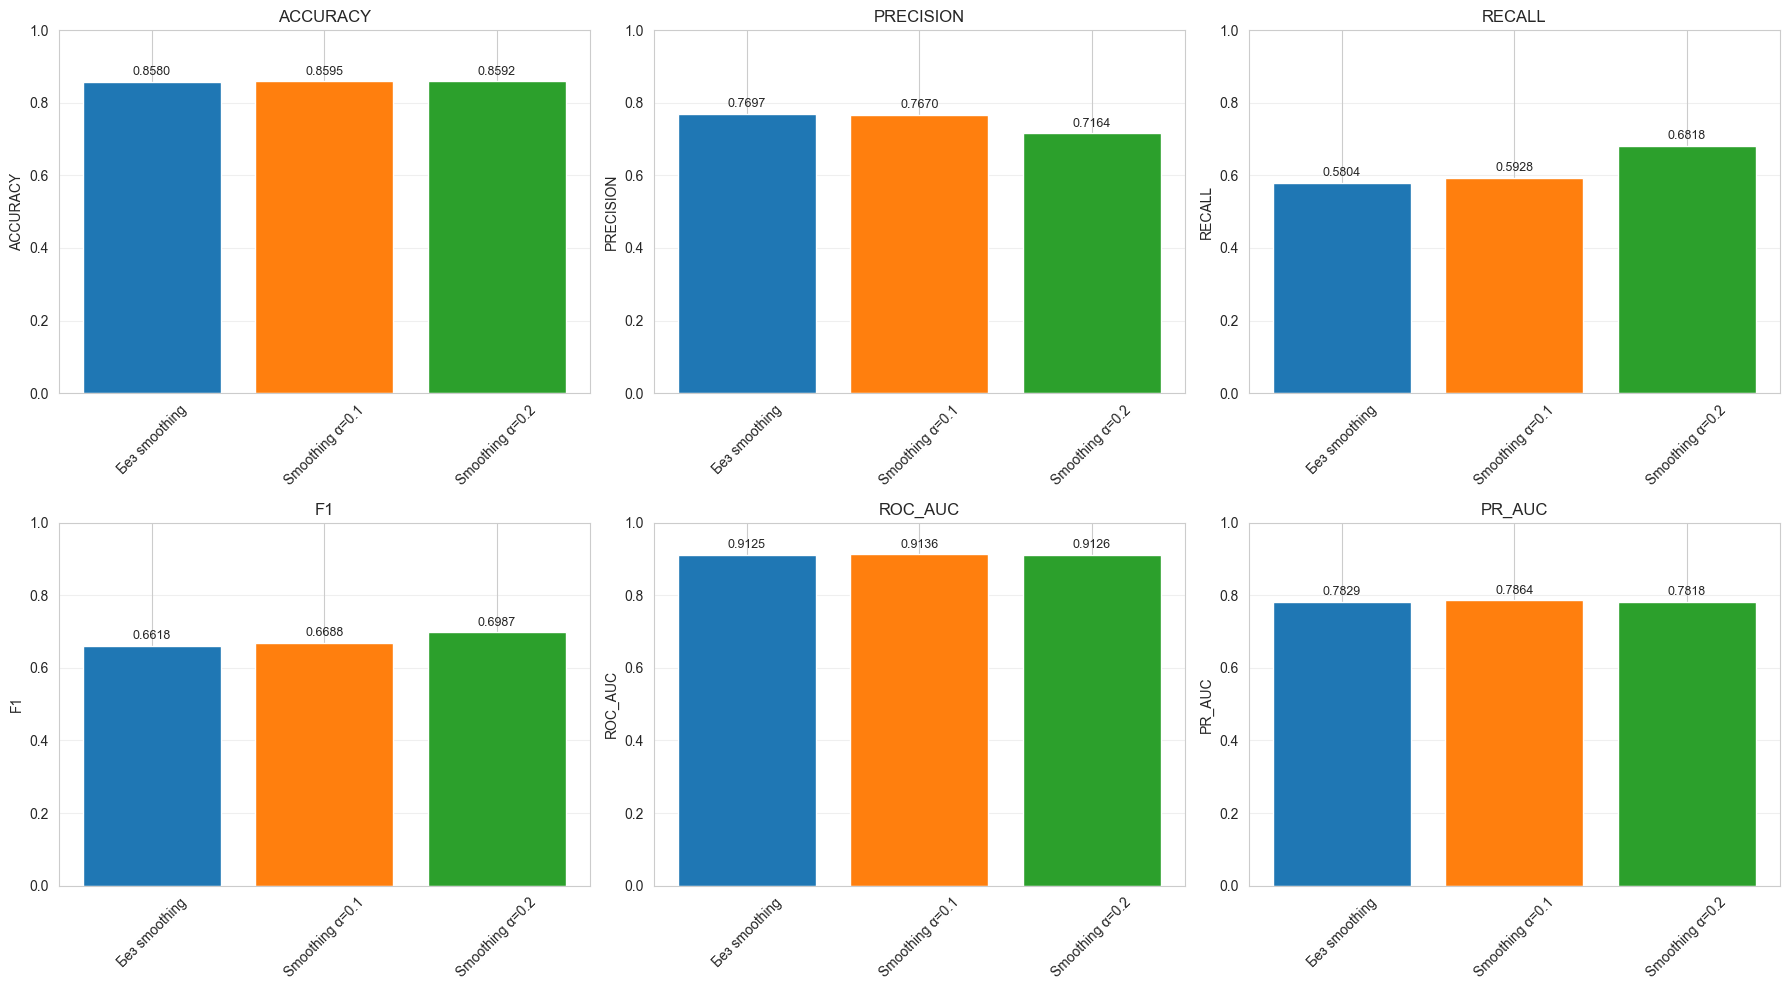

In [8]:
class LabelSmoothingBCEWithLogitsLoss(nn.Module):
    def __init__(self, smoothing=0.1):
        super().__init__()
        self.smoothing = smoothing
    
    def forward(self, logits, targets):
        targets_smooth = targets * (1 - self.smoothing) + (1 - targets) * self.smoothing
        return F.binary_cross_entropy_with_logits(logits, targets_smooth)

def train_with_smoothing(smoothing, name):
    train_loader = data_module.train_dataloader()
    val_loader = data_module.val_dataloader()
    
    model = MLPClassifier(
        input_dim=data_module.input_dim,
        n_classes=1,
        hidden_dims=[128, 64, 32],
        activation='relu',
        dropout=0.3
    )
    
    if smoothing > 0:
        loss_fn = LabelSmoothingBCEWithLogitsLoss(smoothing=smoothing)
    else:
        loss_fn = nn.BCEWithLogitsLoss()
    
    lightning_module = BaseLightningModule(
        model=model,
        loss_fn=loss_fn,
        optimizer_type='adam',
        learning_rate=1e-3,
        task_type='binary_classification'
    )
    
    trainer = Trainer(
        max_epochs=15,
        enable_progress_bar=False,
        enable_model_summary=False
    )
    
    trainer.fit(lightning_module, train_loader, val_loader)
    
    lightning_module.eval()
    model.eval()
    
    y_true_all = []
    y_proba_all = []
    
    with torch.no_grad():
        for batch in val_loader:
            x, y = batch
            logits = model(x).squeeze()
            proba = torch.sigmoid(logits)
            y_true_all.append(y.numpy())
            y_proba_all.append(proba.numpy())
    
    y_true = np.concatenate(y_true_all)
    y_proba = np.concatenate(y_proba_all)
    y_pred = (y_proba >= 0.5).astype(int)
    
    y_true_tensor = torch.FloatTensor(y_true)
    y_proba_tensor = torch.FloatTensor(y_proba)
    y_pred_tensor = torch.FloatTensor(y_pred)
    y_true_long = y_true_tensor.long()
    
    accuracy_metric = BinaryAccuracy()
    precision_metric = BinaryPrecision()
    recall_metric = BinaryRecall()
    f1_metric = BinaryF1Score()
    roc_auc_metric = BinaryAUROC()
    pr_auc_metric = BinaryAveragePrecision()
    
    return {
        'name': name,
        'accuracy': accuracy_metric(y_pred_tensor, y_true_long).item(),
        'precision': precision_metric(y_pred_tensor, y_true_long).item(),
        'recall': recall_metric(y_pred_tensor, y_true_long).item(),
        'f1': f1_metric(y_pred_tensor, y_true_long).item(),
        'roc_auc': roc_auc_metric(y_proba_tensor, y_true_long).item(),
        'pr_auc': pr_auc_metric(y_proba_tensor, y_true_long).item()
    }

print("Обучение без label smoothing...")
results_no_smooth = train_with_smoothing(0.0, 'Без smoothing')

print("\nОбучение с label smoothing (α=0.1)...")
results_smooth_01 = train_with_smoothing(0.1, 'Smoothing α=0.1')

print("\nОбучение с label smoothing (α=0.2)...")
results_smooth_02 = train_with_smoothing(0.2, 'Smoothing α=0.2')

smoothing_results = pd.DataFrame([results_no_smooth, results_smooth_01, results_smooth_02])
print("\nСравнение результатов:")
print(smoothing_results.round(4))

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'pr_auc']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 3, idx % 3]
    bars = ax.bar(smoothing_results['name'], smoothing_results[metric], 
                  color=['#1f77b4', '#ff7f0e', '#2ca02c'])
    ax.set_ylabel(metric.upper())
    ax.set_title(f'{metric.upper()}')
    ax.set_ylim(0, 1)
    ax.grid(True, alpha=0.3, axis='y')
    ax.tick_params(axis='x', rotation=45)
    
    for bar, val in zip(bars, smoothing_results[metric]):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{val:.4f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


## 8. Подбор порога на готовой модели

Порог по умолчанию для бинарной классификации - 0.5. Однако оптимальный порог зависит от задачи и может быть найден на основе различных метрик:

- Максимизация F1-score
- Максимизация Youden's J statistic (TPR - FPR)
- Балансирование Precision и Recall
- Оптимизация для конкретной бизнес-метрики

Найдем оптимальный порог для максимизации F1-score и сравним метрики при разных порогах.

Обучаем модель и затем перебираем различные пороги на валидационной выборке, вычисляя метрики для каждого порога.


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 0: accuracy=0.2109, precision=0.2109, recall=1.0000, f1=0.3484, roc_auc=0.4727, pr_auc=0.1999
Epoch 0: accuracy=0.8508, precision=0.7202, recall=0.6140, f1=0.6629, roc_auc=0.9090, pr_auc=0.7728
Epoch 1: accuracy=0.8551, precision=0.7188, recall=0.6475, f1=0.6813, roc_auc=0.9118, pr_auc=0.7807
Epoch 2: accuracy=0.8564, precision=0.7367, recall=0.6218, f1=0.6744, roc_auc=0.9123, pr_auc=0.7825
Epoch 3: accuracy=0.8572, precision=0.7457, recall=0.6114, f1=0.6719, roc_auc=0.9125, pr_auc=0.7834
Epoch 4: accuracy=0.8581, precision=0.7462, recall=0.6169, f1=0.6754, roc_auc=0.9130, pr_auc=0.7844
Epoch 5: accuracy=0.8587, precision=0.7508, recall=0.6128, f1=0.6748, roc_auc=0.9131, pr_auc=0.7850
Epoch 6: accuracy=0.8589, precision=0.7531, recall=0.6107, f1=0.6745, roc_auc=0.9134, pr_auc=0.7855
Epoch 7: accuracy=0.8592, precision=0.7545, recall=0.6100, f1=0.6746, roc_auc=0.9136, pr_auc=0.7860
Epoch 8: accuracy=0.8593, precision=0.7566, recall=0.6075, f1=0.6739, roc_auc=0.9135, pr_auc=0.7857


`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: accuracy=0.8595, precision=0.7576, recall=0.6072, f1=0.6741, roc_auc=0.9129, pr_auc=0.7847
Оптимальный порог (F1): 0.3300

Метрики при пороге 0.5:
  Accuracy: 0.8594
  Precision: 0.7625
  Recall: 0.5988
  F1: 0.6708

Метрики при оптимальном пороге 0.3300:
  Accuracy: 0.8455
  Precision: 0.6526
  Recall: 0.7583
  F1: 0.7015


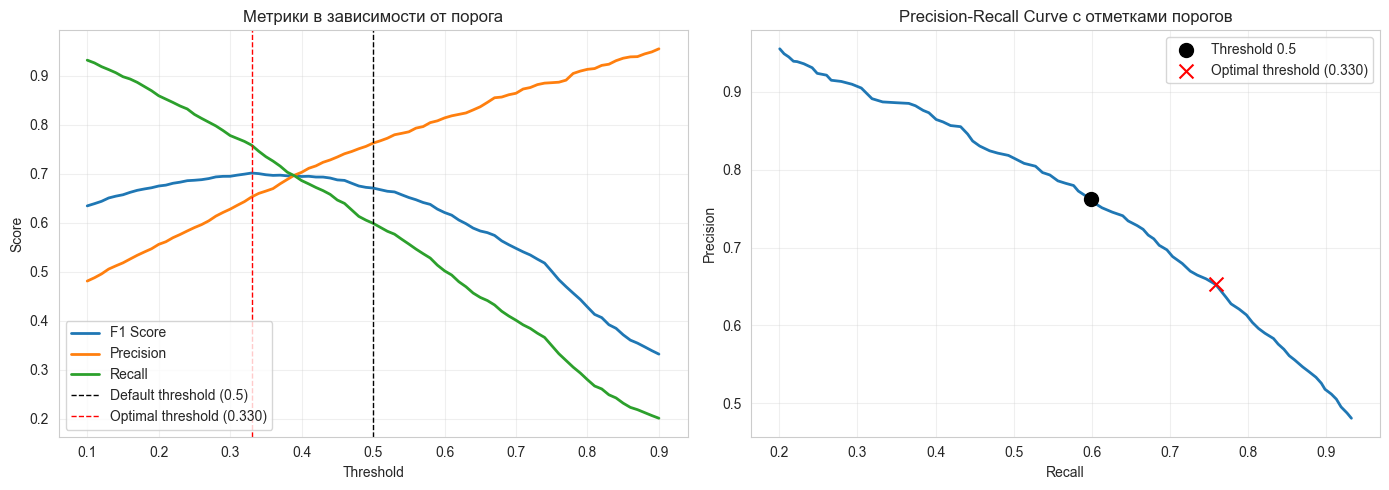

In [9]:
train_loader = data_module.train_dataloader()
val_loader = data_module.val_dataloader()

model = MLPClassifier(
    input_dim=data_module.input_dim,
    n_classes=1,
    hidden_dims=[128, 64, 32],
    activation='relu',
    dropout=0.3
)

loss_fn = nn.BCEWithLogitsLoss()
lightning_module = BaseLightningModule(
    model=model,
    loss_fn=loss_fn,
    optimizer_type='adam',
    learning_rate=1e-3,
    task_type='binary_classification'
)

trainer = Trainer(
    max_epochs=15,
    enable_progress_bar=False,
    enable_model_summary=False
)

trainer.fit(lightning_module, train_loader, val_loader)

lightning_module.eval()
model.eval()

y_true_all = []
y_proba_all = []

with torch.no_grad():
    for batch in val_loader:
        x, y = batch
        logits = model(x).squeeze()
        proba = torch.sigmoid(logits)
        y_true_all.append(y.numpy())
        y_proba_all.append(proba.numpy())

y_true = np.concatenate(y_true_all)
y_proba = np.concatenate(y_proba_all)

thresholds = np.linspace(0.1, 0.9, 81)
f1_scores = []
precisions = []
recalls = []

y_true_tensor = torch.FloatTensor(y_true)
y_proba_tensor = torch.FloatTensor(y_proba)
y_true_long = y_true_tensor.long()

f1_metric = BinaryF1Score()
precision_metric = BinaryPrecision()
recall_metric = BinaryRecall()

for threshold in thresholds:
    y_pred = (y_proba >= threshold).astype(int)
    y_pred_tensor = torch.FloatTensor(y_pred)
    f1_scores.append(f1_metric(y_pred_tensor, y_true_long).item())
    precisions.append(precision_metric(y_pred_tensor, y_true_long).item())
    recalls.append(recall_metric(y_pred_tensor, y_true_long).item())

f1_scores = np.array(f1_scores)
precisions = np.array(precisions)
recalls = np.array(recalls)

optimal_threshold_f1 = thresholds[np.argmax(f1_scores)]
optimal_f1 = np.max(f1_scores)

y_pred_default = (y_proba >= 0.5).astype(int)
y_pred_optimal = (y_proba >= optimal_threshold_f1).astype(int)

y_pred_default_tensor = torch.FloatTensor(y_pred_default)
y_pred_optimal_tensor = torch.FloatTensor(y_pred_optimal)

accuracy_metric = BinaryAccuracy()

print(f"Оптимальный порог (F1): {optimal_threshold_f1:.4f}")
print(f"\nМетрики при пороге 0.5:")
print(f"  Accuracy: {accuracy_metric(y_pred_default_tensor, y_true_long).item():.4f}")
print(f"  Precision: {precision_metric(y_pred_default_tensor, y_true_long).item():.4f}")
print(f"  Recall: {recall_metric(y_pred_default_tensor, y_true_long).item():.4f}")
print(f"  F1: {f1_metric(y_pred_default_tensor, y_true_long).item():.4f}")

print(f"\nМетрики при оптимальном пороге {optimal_threshold_f1:.4f}:")
print(f"  Accuracy: {accuracy_metric(y_pred_optimal_tensor, y_true_long).item():.4f}")
print(f"  Precision: {precision_metric(y_pred_optimal_tensor, y_true_long).item():.4f}")
print(f"  Recall: {recall_metric(y_pred_optimal_tensor, y_true_long).item():.4f}")
print(f"  F1: {f1_metric(y_pred_optimal_tensor, y_true_long).item():.4f}")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(thresholds, f1_scores, label='F1 Score', linewidth=2)
axes[0].plot(thresholds, precisions, label='Precision', linewidth=2)
axes[0].plot(thresholds, recalls, label='Recall', linewidth=2)
axes[0].axvline(x=0.5, color='k', linestyle='--', label='Default threshold (0.5)', linewidth=1)
axes[0].axvline(x=optimal_threshold_f1, color='r', linestyle='--', label=f'Optimal threshold ({optimal_threshold_f1:.3f})', linewidth=1)
axes[0].set_xlabel('Threshold')
axes[0].set_ylabel('Score')
axes[0].set_title('Метрики в зависимости от порога')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(recalls, precisions, linewidth=2)
recall_default = recall_metric(y_pred_default_tensor, y_true_long).item()
precision_default = precision_metric(y_pred_default_tensor, y_true_long).item()
recall_optimal = recall_metric(y_pred_optimal_tensor, y_true_long).item()
precision_optimal = precision_metric(y_pred_optimal_tensor, y_true_long).item()
axes[1].scatter(recall_default, precision_default,
               s=100, color='k', marker='o', label='Threshold 0.5', zorder=5)
axes[1].scatter(recall_optimal, precision_optimal,
               s=100, color='r', marker='x', label=f'Optimal threshold ({optimal_threshold_f1:.3f})', zorder=5)
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curve с отметками порогов')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 9. Калибровка: Температурное масштабирование

Калибровка модели - это процесс приведения предсказанных вероятностей к реальным частотам событий.

**Температурное масштабирование** - простой метод калибровки, который применяет параметр температуры $T$ к логитам:

$$p_{calibrated} = \sigma\left(\frac{logits}{T}\right)$$

где $T > 0$ - параметр температуры, который подбирается на валидационной выборке.

**Калибровочная диаграмма (Calibration Curve)** показывает зависимость между предсказанными вероятностями и фактическими частотами:

- Идеально откалиброванная модель: $P(y=1|p_{pred}=p) = p$ для всех $p$
- Недокалиброванная модель: предсказанные вероятности не соответствуют реальным частотам

**Brier Score** - метрика калибровки:

$$BS = \frac{1}{N}\sum_{i=1}^{N}(p_i - y_i)^2$$

где $p_i$ - предсказанная вероятность, $y_i$ - истинная метка. Чем меньше Brier Score, тем лучше калибровка.

Обучаем модель, затем применяем температурное масштабирование на валидационной выборке и сравниваем калибровку до и после.


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 0: accuracy=0.7891, precision=0.0000, recall=0.0000, f1=0.0000, roc_auc=0.5541, pr_auc=0.2258
Epoch 0: accuracy=0.8616, precision=0.7545, recall=0.6237, f1=0.6829, roc_auc=0.9100, pr_auc=0.7766
Epoch 1: accuracy=0.8611, precision=0.7540, recall=0.6224, f1=0.6819, roc_auc=0.9119, pr_auc=0.7813
Epoch 2: accuracy=0.8604, precision=0.7633, recall=0.6033, f1=0.6740, roc_auc=0.9118, pr_auc=0.7814
Epoch 3: accuracy=0.8602, precision=0.7660, recall=0.5988, f1=0.6721, roc_auc=0.9118, pr_auc=0.7824
Epoch 4: accuracy=0.8604, precision=0.7679, recall=0.5970, f1=0.6718, roc_auc=0.9122, pr_auc=0.7835
Epoch 5: accuracy=0.8605, precision=0.7670, recall=0.5988, f1=0.6726, roc_auc=0.9126, pr_auc=0.7842
Epoch 6: accuracy=0.8607, precision=0.7629, recall=0.6062, f1=0.6756, roc_auc=0.9129, pr_auc=0.7848
Epoch 7: accuracy=0.8607, precision=0.7606, recall=0.6100, f1=0.6770, roc_auc=0.9131, pr_auc=0.7852
Epoch 8: accuracy=0.8609, precision=0.7585, recall=0.6144, f1=0.6789, roc_auc=0.9134, pr_auc=0.7856


`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: accuracy=0.8609, precision=0.7547, recall=0.6205, f1=0.6811, roc_auc=0.9131, pr_auc=0.7848
Оптимальная температура: 1.2129

Brier Score до калибровки: 0.0982
Brier Score после калибровки: 0.0981


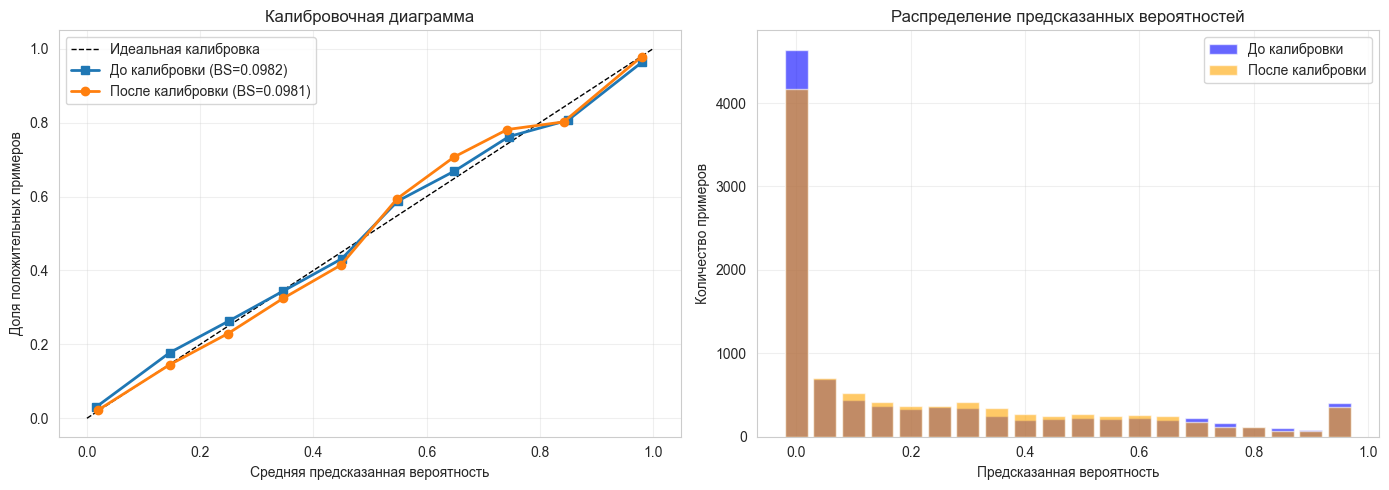


Сравнение метрик до и после калибровки:
        Metric  До калибровки  После калибровки
0  Brier Score         0.0982            0.0981
1      ROC-AUC         0.9134            0.9134
2       PR-AUC         0.7842            0.7842


In [10]:
class TemperatureScaling(nn.Module):
    def __init__(self, temperature=1.0):
        super().__init__()
        self.temperature = nn.Parameter(torch.ones(1) * temperature)
    
    def forward(self, logits):
        return logits / self.temperature

train_loader = data_module.train_dataloader()
val_loader = data_module.val_dataloader()

model = MLPClassifier(
    input_dim=data_module.input_dim,
    n_classes=1,
    hidden_dims=[128, 64, 32],
    activation='relu',
    dropout=0.3
)

loss_fn = nn.BCEWithLogitsLoss()
lightning_module = BaseLightningModule(
    model=model,
    loss_fn=loss_fn,
    optimizer_type='adam',
    learning_rate=1e-3,
    task_type='binary_classification'
)

trainer = Trainer(
    max_epochs=15,
    enable_progress_bar=False,
    enable_model_summary=False
)

trainer.fit(lightning_module, train_loader, val_loader)

model.eval()

y_true_val = []
y_logits_val = []

with torch.no_grad():
    for batch in val_loader:
        x, y = batch
        logits = model(x).squeeze()
        y_true_val.append(y.numpy())
        y_logits_val.append(logits.numpy())

y_true_val = np.concatenate(y_true_val)
y_logits_val = np.concatenate(y_logits_val)
y_proba_val = torch.sigmoid(torch.FloatTensor(y_logits_val)).numpy()

temperature_scaler = TemperatureScaling(temperature=1.0)
optimizer = torch.optim.Adam(temperature_scaler.parameters(), lr=0.01)

y_true_tensor = torch.FloatTensor(y_true_val)
y_logits_tensor = torch.FloatTensor(y_logits_val)

temperature_scaler.train()
for epoch in range(100):
    optimizer.zero_grad()
    scaled_logits = temperature_scaler(y_logits_tensor)
    loss = F.binary_cross_entropy_with_logits(scaled_logits, y_true_tensor)
    loss.backward()
    optimizer.step()

temperature_scaler.eval()
optimal_temperature = temperature_scaler.temperature.item()

with torch.no_grad():
    y_logits_calibrated = temperature_scaler(y_logits_tensor).numpy()
    y_proba_calibrated = torch.sigmoid(torch.FloatTensor(y_logits_calibrated)).numpy()

print(f"Оптимальная температура: {optimal_temperature:.4f}")

y_true_val_tensor = torch.FloatTensor(y_true_val)
y_proba_val_tensor = torch.FloatTensor(y_proba_val)
y_proba_calibrated_tensor = torch.FloatTensor(y_proba_calibrated)

def brier_score(preds, target):
    return torch.mean((preds - target.float()) ** 2)

brier_before = brier_score(y_proba_val_tensor, y_true_val_tensor).item()
brier_after = brier_score(y_proba_calibrated_tensor, y_true_val_tensor).item()

print(f"\nBrier Score до калибровки: {brier_before:.4f}")
print(f"Brier Score после калибровки: {brier_after:.4f}")

fraction_of_positives, mean_predicted_value = calibration_curve(
    y_true_val, y_proba_val, n_bins=10, strategy='uniform'
)

fraction_of_positives_cal, mean_predicted_value_cal = calibration_curve(
    y_true_val, y_proba_calibrated, n_bins=10, strategy='uniform'
)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot([0, 1], [0, 1], 'k--', label='Идеальная калибровка', linewidth=1)
axes[0].plot(mean_predicted_value, fraction_of_positives, 's-', label=f'До калибровки (BS={brier_before:.4f})', linewidth=2)
axes[0].plot(mean_predicted_value_cal, fraction_of_positives_cal, 'o-', label=f'После калибровки (BS={brier_after:.4f})', linewidth=2)
axes[0].set_xlabel('Средняя предсказанная вероятность')
axes[0].set_ylabel('Доля положительных примеров')
axes[0].set_title('Калибровочная диаграмма')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

bins = np.linspace(0, 1, 21)
hist_before, _ = np.histogram(y_proba_val, bins=bins)
hist_after, _ = np.histogram(y_proba_calibrated, bins=bins)

axes[1].bar(bins[:-1], hist_before, width=0.04, alpha=0.6, label='До калибровки', color='blue')
axes[1].bar(bins[:-1], hist_after, width=0.04, alpha=0.6, label='После калибровки', color='orange')
axes[1].set_xlabel('Предсказанная вероятность')
axes[1].set_ylabel('Количество примеров')
axes[1].set_title('Распределение предсказанных вероятностей')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

roc_auc_metric = BinaryAUROC()
pr_auc_metric = BinaryAveragePrecision()

y_true_val_long = y_true_val_tensor.long()

roc_auc_before = roc_auc_metric(y_proba_val_tensor, y_true_val_long).item()
pr_auc_before = pr_auc_metric(y_proba_val_tensor, y_true_val_long).item()
roc_auc_after = roc_auc_metric(y_proba_calibrated_tensor, y_true_val_long).item()
pr_auc_after = pr_auc_metric(y_proba_calibrated_tensor, y_true_val_long).item()

comparison_df = pd.DataFrame({
    'Metric': ['Brier Score', 'ROC-AUC', 'PR-AUC'],
    'До калибровки': [
        brier_before,
        roc_auc_before,
        pr_auc_before
    ],
    'После калибровки': [
        brier_after,
        roc_auc_after,
        pr_auc_after
    ]
})

print("\nСравнение метрик до и после калибровки:")
print(comparison_df.round(4))
